In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip -q fashion-product-images-small.zip -d /content/fashion_data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT


In [2]:
import pandas as pd
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths
styles_path = "/content/fashion_data/styles.csv"
images_dir = "/content/fashion_data/images"
filtered_dir = "/content/fashion_data/filtered"

# Read and clean metadata
df = pd.read_csv(styles_path, on_bad_lines='skip')
df = df[['id', 'articleType']]
df.dropna(inplace=True)

# Filter for top 10 most frequent classes with enough images
class_counts = df['articleType'].value_counts()
top_classes = class_counts[class_counts >= 60].nlargest(10).index.tolist()  # 30 train + 30 val
df = df[df['articleType'].isin(top_classes)]

# Split and copy to class folders
if os.path.exists(filtered_dir):
    shutil.rmtree(filtered_dir)
os.makedirs(filtered_dir)

for class_name in top_classes:
    class_df = df[df['articleType'] == class_name]
    train_ids, val_ids = train_test_split(class_df['id'], test_size=0.4, random_state=42)  # 60-40 split

    for split, ids in [('train', train_ids), ('val', val_ids)]:
        split_dir = os.path.join(filtered_dir, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for img_id in ids:
            file_path = os.path.join(images_dir, f"{img_id}.jpg")
            if os.path.exists(file_path):
                try:
                    # Verify image opens
                    with Image.open(file_path) as img:
                        img.verify()
                    shutil.copy(file_path, split_dir)
                except:
                    continue  # Skip corrupted images


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 128
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    directory=os.path.join(filtered_dir, 'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    directory=os.path.join(filtered_dir, 'val'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(train_gen.class_indices.keys())


Found 15274 images belonging to 10 classes.
Found 10191 images belonging to 10 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


478/478 ━━━━━━━━━━━━━━━━━━━━ 1059s 2s/step - accuracy: 0.5997 - loss: 1.9142 - val_accuracy: 0.2686 - val_loss: 10.6551
Epoch 2/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1076s 2s/step - accuracy: 0.7851 - loss: 0.5578 - val_accuracy: 0.7777 - val_loss: 0.6635
Epoch 3/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1061s 2s/step - accuracy: 0.8271 - loss: 0.4478 - val_accuracy: 0.7933 - val_loss: 0.6934
Epoch 4/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1060s 2s/step - accuracy: 0.8451 - loss: 0.4084 - val_accuracy: 0.8694 - val_loss: 0.3886
Epoch 5/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1100s 2s/step - accuracy: 0.8570 - loss: 0.3678 - val_accuracy: 0.8295 - val_loss: 0.4458
Epoch 6/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1058s 2s/step - accuracy: 0.8745 - loss: 0.3289 - val_accuracy: 0.5192 - val_loss: 3.2148
Epoch 7/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 1104s 2s/step - accuracy: 0.8774 - loss: 0.3211 - val_accuracy: 0.6845 - val_loss: 1.0725


In [5]:
import numpy as np
from PIL import Image

# Weather-based suggestions
weather_suggestions = {
    'summer': ['Tshirts', 'Shorts', 'Sandals', 'Caps', 'Handbags'],
    'winter': ['Sweatshirts', 'Coats', 'Jeans', 'Boots'],
    'rainy': ['Coats', 'Sneakers', 'Handbags']
}

# Preprocess image for prediction
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img = np.array(img) / 255.0
    return img.reshape(1, img_size, img_size, 3)

# Predict and recommend based on weather
def predict_and_recommend(image_path, weather):
    image_array = preprocess_image(image_path)
    prediction = model.predict(image_array)
    predicted_idx = np.argmax(prediction)
    predicted_class = class_labels[predicted_idx]

    print(f"Predicted Item: {predicted_class}")

    suitable_items = weather_suggestions.get(weather.lower(), [])
    if predicted_class in suitable_items:
        print(f"This item is suitable for {weather}.")
        print("You can also go for:", [i for i in suitable_items if i != predicted_class])
    else:
        print(f"This item is NOT suitable for {weather}.")
        print(f"Recommended for {weather}: {suitable_items}")


In [30]:
import os

def list_images_by_category(base_dir, category_name):
    """
    Lists all image filenames in a specific category folder under the base directory.

    Args:
        base_dir (str): Path to the train or validation directory.
        category_name (str): Name of the category folder.

    Returns:
        list: Sorted list of image file names in the category, or an empty list if not found.
    """
    category_path = os.path.join(base_dir, category_name)
    if os.path.isdir(category_path):
        return sorted(os.listdir(category_path))
    else:
        print(f"Category '{category_name}' not found in {base_dir}.")
        return []

# Example usage:
train_dir = "/content/fashion_data/filtered/train"
val_dir = "/content/fashion_data/filtered/val"

# Replace 'T-shirt' with the actual category name you're interested in
category = "Handbags"

train_images = list_images_by_category(train_dir, category)
val_images = list_images_by_category(val_dir, category)

print(f"Train images for '{category}':", train_images)
print(f"Validation images for '{category}':", val_images)


Train images for 'Handbags': ['10196.jpg', '10199.jpg', '10200.jpg', '10203.jpg', '10205.jpg', '10207.jpg', '10208.jpg', '10209.jpg', '10213.jpg', '10214.jpg', '10215.jpg', '10221.jpg', '10222.jpg', '10224.jpg', '10226.jpg', '10227.jpg', '10231.jpg', '10242.jpg', '10243.jpg', '10244.jpg', '10245.jpg', '10247.jpg', '10249.jpg', '10252.jpg', '10253.jpg', '10254.jpg', '10320.jpg', '10321.jpg', '10322.jpg', '10680.jpg', '10724.jpg', '10725.jpg', '10728.jpg', '10729.jpg', '10732.jpg', '10733.jpg', '10734.jpg', '10735.jpg', '10736.jpg', '10737.jpg', '12348.jpg', '12493.jpg', '12733.jpg', '12734.jpg', '14135.jpg', '14790.jpg', '14792.jpg', '14794.jpg', '14796.jpg', '14797.jpg', '14799.jpg', '14803.jpg', '14804.jpg', '14805.jpg', '14807.jpg', '14808.jpg', '14809.jpg', '14810.jpg', '14811.jpg', '14813.jpg', '14814.jpg', '14817.jpg', '14878.jpg', '14879.jpg', '14880.jpg', '14881.jpg', '14883.jpg', '14885.jpg', '14888.jpg', '15216.jpg', '15297.jpg', '15437.jpg', '15451.jpg', '15665.jpg', '1597.jp

In [31]:
# Example test
image_path = "/content/fashion_data/filtered/val/Handbags/10197.jpg"  # replace with real image path
weather = "winter"

predict_and_recommend(image_path, weather)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted Item: Handbags
This item is NOT suitable for winter.
Recommended for winter: ['Sweatshirts', 'Coats', 'Jeans', 'Boots']


In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Save entire model
model.save("fashion_cnn_model.h5")

# Optionally save class labels (for Flask prediction use)
import json
with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)


319/319 ━━━━━━━━━━━━━━━━━━━━ 130s 407ms/step
Classification Report:
              precision    recall  f1-score   support

Casual Shoes       0.71      0.93      0.80      1138
    Handbags       0.97      0.95      0.96       704
       Heels       0.97      0.85      0.91       530
      Kurtas       0.95      0.91      0.93       738
      Shirts       0.89      0.87      0.88      1287
Sports Shoes       0.85      0.58      0.69       815
  Sunglasses       1.00      1.00      1.00       430
        Tops       0.60      0.74      0.66       705
     Tshirts       0.91      0.87      0.89      2827
     Watches       0.99      0.98      0.98      1017

    accuracy                           0.87     10191
   macro avg       0.88      0.87      0.87     10191
weighted avg       0.88      0.87      0.87     10191



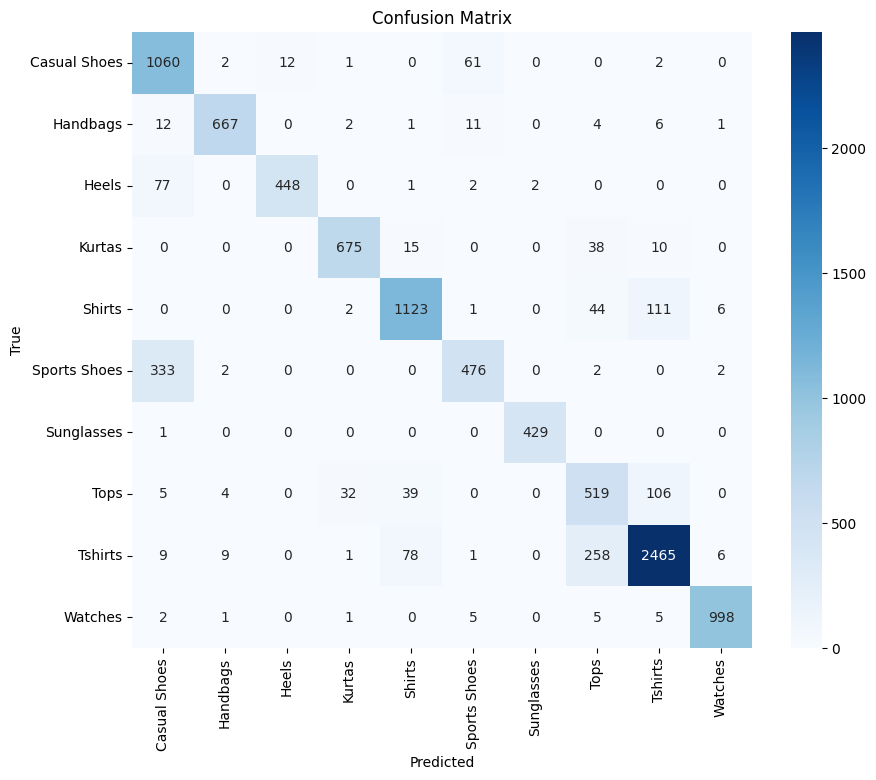

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation data
val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

# Classification Report (F1, precision, recall)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
